## Этап 1. Импортирование библиотек, настроек. Знакомство с данными.

### 1.1 Импортирование библиотек, настроек.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
from pymystem3 import Mystem # импортируем pymystem3
from collections import Counter
pd.options.display.float_format = '{:,.2f}'.format

### 1.2 Чтение файлов и знакомство с данными

Прочитаем датасет с данными и сохраним его в переменую **logs_exp**:

In [2]:
logs_exp = pd.read_csv('logs_exp.csv', sep = "\t")

Посмотрим на 10 случайных строк датасета:

In [3]:
logs_exp.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
46958,MainScreenAppear,8652597388469225782,1564732911,247
238574,CartScreenAppear,4239243414870948721,1565198137,248
131711,OffersScreenAppear,3862048291994678733,1564934754,248
226329,MainScreenAppear,3930295931691686240,1565178789,248
171087,MainScreenAppear,5674515761085325853,1565027108,248
87998,CartScreenAppear,4906536227671487464,1564831355,246
69110,MainScreenAppear,5082109226266777517,1564769576,248
35793,OffersScreenAppear,5670515820397086703,1564687327,246
243623,OffersScreenAppear,3863873029567317821,1565209579,248
96285,MainScreenAppear,7934103980026732017,1564843759,248


Каждая запись в логе — это действие пользователя, или событие:
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [4]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет. В дальнейшем переимениуем столбцы, отметим, что столбец **EventTimestamp** в unix-time, в дальнейшем добавим два столбцам с датой и временем и отдельно с датой. 

Проверим на явные дубликаты:

In [5]:
logs_exp.duplicated().sum()

413

Дубликатов 413 штук, в дальнейшем избавимся от них.

**Вывод:**

* Таблица имеет 4 столбца
* Таблица имеет 244126 строк
* Пропусков нет
* Для работы в дальнейем необходимо добавить два столбца с датой и временем и с датой
* Имеется 413 дубликатов
* Столбцы для удобства переимениуем.

## Этап 2. Предобработка данных

### 2.1 Изменение столбцов

Изменим название столбцов для удобства:

In [6]:
logs_exp.columns= ['event', 'id', 'event_seconds', 'exp_id']

Посмотрим на результат:

In [7]:
logs_exp.head(5)

,event,id,event_seconds,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Изменили столбцы на более удобные.

### 2.2 Добавление столбцов с датой и временем и с датой

Как ранее было отмечено, столбец **event_time** имеет тип данных выраженных целыми числами(секундами). Необходимо добавить два столбца с датой и временем и отдельно с датой :

In [8]:
logs_exp['event_time'] = pd.to_datetime(logs_exp['event_seconds'], unit = 's' )
logs_exp['date'] = logs_exp['event_time'].astype('datetime64[D]')

Посмотрим на таблицу и внесенные изменения:

In [9]:
logs_exp.tail(5)

,event,id,event_seconds,exp_id,event_time,date
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


Добавили два столбца с датой и временем и с датой.

### 2.3 Удаление дубликатов

Ранее было выявлено, что в датасете имеется 413 дубликатов, избавимся от них:

In [10]:
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

Проверим - отсались ли дубликаты:

In [11]:
logs_exp.duplicated().sum()

0

Успешно удалены дубликаты.

## Этап 3. Изучение и проверка данных

### 3.1 Сколько всего событий в логе?

Посмотрим сколько имеется всего событий в логе:

In [12]:
print('В логе содержатся {} событий'.format(logs_exp.shape[0]))

В логе содержатся 243713 событий


### 3.2 Сколько всего пользователей в логе?

Посмотрим сколько имеется всего пользователей в логе:

In [13]:
print('В логе содержатся данные {} пользователей'.format(logs_exp['id'].nunique()))

В логе содержатся данные 7551 пользователей


### 3.3 Сколько в среднем событий приходится на пользователя?

Посмотрим сколько в среднем событий приходится на пользователя:

In [14]:
print('В среднем на пользователя приходится {:.0f} события'.format(logs_exp.shape[0] / logs_exp['id'].nunique()))

В среднем на пользователя приходится 32 события


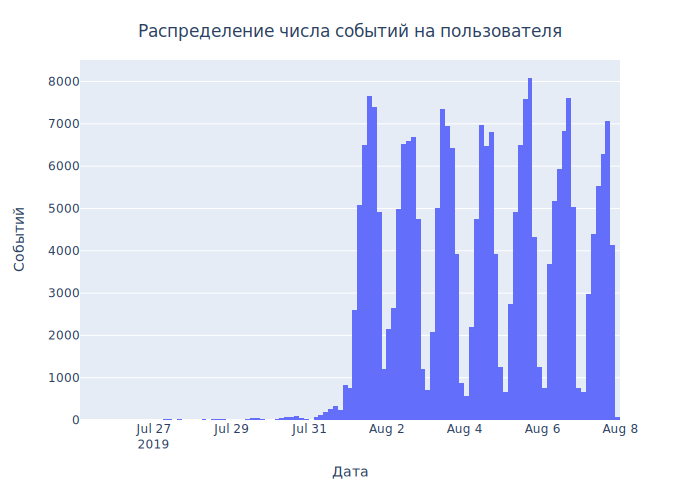

In [15]:
fig = px.histogram(logs_exp, x='event_time', nbins=150,  
                   labels=dict(count = "Количество событий", event = "Число пользователей"))
fig.update_layout(title={'text': "Распределение числа событий на пользователя", 'xanchor': 'center', 'y':0.95,
        'x':0.5},
                  yaxis_title="Событий", xaxis_title='Дата',  )
fig.show("svg")

Посмотрим количество событий по дням:

In [16]:
events_day = logs_exp.groupby('date')['event'].count()
events_day.to_frame()

,event
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


Посмотрим количество уникальных пользователей по дням:

In [17]:
nunuq_id_day =  logs_exp.groupby('date')['id'].nunique()
nunuq_id_day.to_frame()

,id
date,
2019-07-25,7
2019-07-26,22
2019-07-27,39
2019-07-28,69
2019-07-29,135
2019-07-30,296
2019-07-31,924
2019-08-01,3703
2019-08-02,3647


Обеъдиним таблицы в одну:

In [18]:
days = pd.merge(events_day,nunuq_id_day, on = 'date')

Посчитаем количество уникальный пользователей на каждый день в отдельный столбец **event_for_id**:

In [19]:
days['event_for_id'] = days['event'] / days['id']

Посмотрим итоговый вариант таблицы:

In [20]:
days

,event,id,event_for_id
date,,,
2019-07-25,9,7,1.29
2019-07-26,31,22,1.41
2019-07-27,55,39,1.41
2019-07-28,105,69,1.52
2019-07-29,184,135,1.36
2019-07-30,412,296,1.39
2019-07-31,2030,924,2.20
2019-08-01,36141,3703,9.76
2019-08-02,35554,3647,9.75


Построим также гистрограмму:

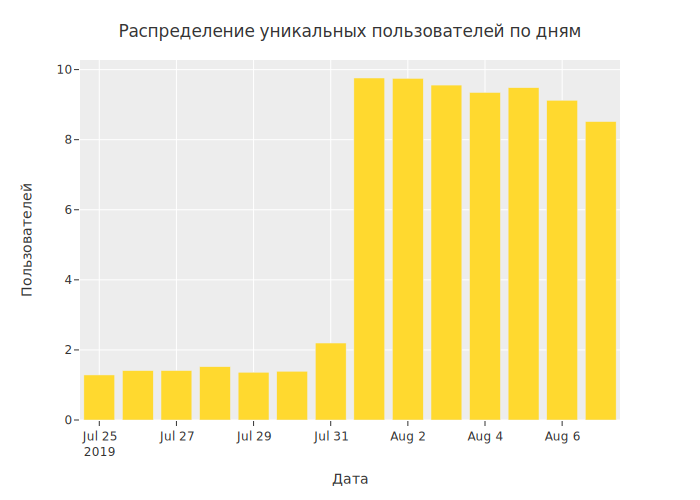

In [21]:
fig = px.bar(days.reset_index(), x='date', y='event_for_id', color_discrete_sequence=['rgb(255,217,47)'])
fig.update_layout(title={'text': "Распределение уникальных пользователей по дням", 'xanchor': 'center', 'y':0.95,
        'x':0.5},
                  yaxis_title="Пользователей", xaxis_title='Дата',  )
fig.layout.template = 'ggplot2'
fig.show("svg")

### 3.4 За какой период данные?

Посмотрим начальную и конечную дату в логах:

In [22]:
logs_exp

,event,id,event_seconds,exp_id,event_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [23]:
print('Данные предоставлены с {} по {} число'.format(logs_exp['event_time'].min(), logs_exp['event_time'].max()))

Данные предоставлены с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 число


### 3.5 Гистограмма по дате и времени. Можно ли быть уверенным, что одинаково полные данные за весь период?

Построим гистограмму по дате и времени и посмотрим на распределение:

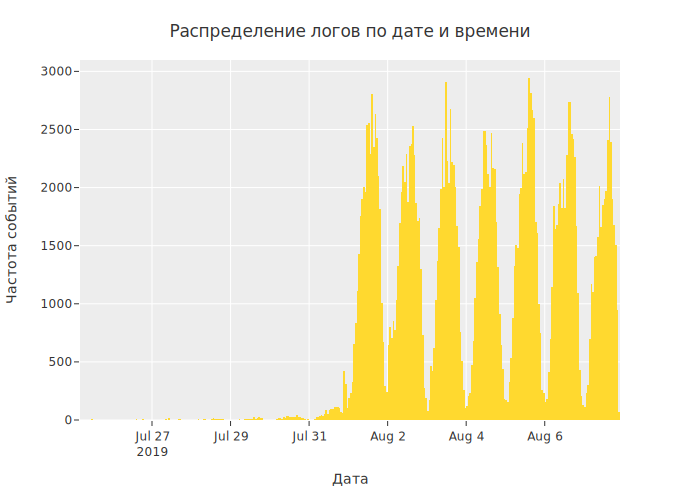

In [24]:
fig = px.histogram(logs_exp, x="event_time",  color_discrete_sequence=['rgb(255,217,47)'])
fig.update_layout(title={'text': "Распределение логов по дате и времени", 'xanchor': 'center', 'y':0.95,
        'x':0.5},
                  yaxis_title="Частота событий", xaxis_title='Дата',  )
fig.layout.template = 'ggplot2'
fig.show("svg")

Как можно заметить по распределению, полные данные имеются с 2019-08-01, за одну неделю. 

### 3.6 Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени имеются на самом деле?

Данные за первую неделю неполные, их отбросим, то есть данные по 2019-07-31 включительно. Так как данные полные лишь с 2019-08-01, оставим их, сохранив в переменную **filt_logs_exp**:

In [25]:
filt_logs_exp = logs_exp.loc[logs_exp['date'] >= '2019-08-01']

Сохранили отфильтрованные данные. Данные имеются за одну неделю.

### 3.7 Много ли событий и пользователей  потеряли, отбросив старые данные?

Посчитаем сколько событий и пользователей потеряли, отброс старые данные в количественном и процентном выражении:

In [26]:
print('До того, как очистили старые данные было {} событий, после очистки осталось {} событий. Отбросив старые данные потеряли {} событий, в процентном соотношении {:.2%}'.format(logs_exp.shape[0], filt_logs_exp.shape[0], logs_exp.shape[0] - filt_logs_exp.shape[0],(logs_exp.shape[0] - filt_logs_exp.shape[0])/logs_exp.shape[0]))
print('До того, как очистили старые данные было {} пользователей, после очистки осталось {} пользователей. Отбросив старые данные потеряли данные {} пользователей, в процентном соотношении {:.2%}'.format(logs_exp['id'].nunique(), filt_logs_exp['id'].nunique(), logs_exp['id'].nunique() - filt_logs_exp['id'].nunique(),(logs_exp['id'].nunique() - filt_logs_exp['id'].nunique())/logs_exp['id'].nunique()))


До того, как очистили старые данные было 243713 событий, после очистки осталось 240887 событий. Отбросив старые данные потеряли 2826 событий, в процентном соотношении 1.16%
До того, как очистили старые данные было 7551 пользователей, после очистки осталось 7534 пользователей. Отбросив старые данные потеряли данные 17 пользователей, в процентном соотношении 0.23%


### 3.8 Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

Проверим сколько уникальных пользователей содержится в каждой из экспермиентальных групп:

In [27]:
filt_logs_exp['exp_id'].value_counts()
filt_logs_exp.groupby('exp_id')['id'].nunique().to_frame()

,id
exp_id,
246,2484
247,2513
248,2537


Также проверим количество действий этими пользователями:

In [28]:
filt_logs_exp.groupby('exp_id')['id'].count().to_frame()

,id
exp_id,
246,79302
247,77022
248,84563


Убедились, что данные из всех трех эксприментальных групп имеются и количество пользователей примерно равно.

## Этап 4. Изучение воронки событий

### 4.1 Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

Посмотрим какие встречаются события и как часто они встречаются:

In [29]:
filt_logs_exp['event'].value_counts().to_frame()

,event
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Таким образом у нас имеются 5 групп событий:
* MainScreenAppear - Переход на главный экран, встречается 117328 раз
* OffersScreenAppear - Появление экрана с предложениями, встречается 46333 раз
* CartScreenAppear	- Переход на экран с корзиной, встречается 42393 раз
* PaymentScreenSuccessful - Экран с успешной оплатой, встречается 33918 раз
* Tutorial - Руководство, встречается 1005 раз

Каждый пользователь может несколько раз переходить на главный экран, как и видеть экран с предложениями. Также в иерархии последовательности строка с руководством (**Tutorial**) здесь не совсем к месту, ибо руководство можно посмотреть в любой отрезок времени, многие пользователи совершают покупки не читая руководство.

### 4.2 Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

Посмотрим сколько уникальных пользователей совершили каждое из событий помимо знакомства с  руководством(**Tutorial**):

In [30]:
uniq_id_event = filt_logs_exp.groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
uniq_id_event['percent'] = uniq_id_event['id']/ uniq_id_event['id'][0] * 100
uniq_id_event[:4]

,id,percent
event,,
MainScreenAppear,7419,100.00
OffersScreenAppear,4593,61.91
CartScreenAppear,3734,50.33
PaymentScreenSuccessful,3539,47.70


In [31]:
filt_logs_exp['id'].nunique()

7534

In [32]:
(uniq_id_event['id'] / filt_logs_exp['event'].value_counts() * 100).to_frame().rename(columns={0:'percent'})

,percent
event,
MainScreenAppear,6.32
OffersScreenAppear,9.91
CartScreenAppear,8.83
PaymentScreenSuccessful,10.43
Tutorial,83.58


Отдельно посмотрим сколько уникальных пользователей, которые познакомились с руководством:

In [33]:
uniq_id_event['id'][4:].to_frame()

,id
event,
Tutorial,840


Таким образом можно заметить, что после перехода с главного экрана на экран с предложениями остались 4593 пользователя, что составляет 62% от всех, кто изначально увидел главный экран. На этапе перехода в корзину перешло 3734 пользователя, что составляет 50% от тех, кто был на главном экране. На этапе успешной оплаты теряется еще 2,5 %, этот этап был у 3539 пользователей. Что касаемо руководства, то его прошли 830 пользователя.

In [34]:
uniq_id_event = filt_logs_exp.groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
uniq_id_event['percent'] = uniq_id_event['id']/ filt_logs_exp['id'].nunique() * 100
uniq_id_event[:4]

,id,percent
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


### 4.3 Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Ранее было обращено внимание на то, что руководство (**Tutorial**) не несет ценности для воронки, с руководством-инструкцией можно познакомиться в любой момент, но большинство пользователей, судя по цифрам его пропускают, убедимся в том, что действительно знакомство с руководством может встречаться в любом порядке:

In [35]:
tutor = filt_logs_exp.query('event == "Tutorial"') # Создание переменной, в которой встречается лишь **Tutorial**
(filt_logs_exp.query('id in @tutor.id'). # Выберем те **id** которые проходили руководство
 sort_values(['id','event_time']) # Сортируем по **id** и по времени события
 .tail(15). # Выведем 15 строк с конца
 reset_index(drop=True)) # Сбросим индекс

,event,id,event_seconds,exp_id,event_time,date
0,MainScreenAppear,9210082518034880206,1564983801,248,2019-08-05 05:43:21,2019-08-05
1,MainScreenAppear,9212377414136562136,1565191006,248,2019-08-07 15:16:46,2019-08-07
2,Tutorial,9212377414136562136,1565191011,248,2019-08-07 15:16:51,2019-08-07
3,MainScreenAppear,9212377414136562136,1565191017,248,2019-08-07 15:16:57,2019-08-07
4,MainScreenAppear,9212377414136562136,1565191049,248,2019-08-07 15:17:29,2019-08-07
5,MainScreenAppear,9212377414136562136,1565191436,248,2019-08-07 15:23:56,2019-08-07
6,MainScreenAppear,9212377414136562136,1565191445,248,2019-08-07 15:24:05,2019-08-07
7,MainScreenAppear,9212377414136562136,1565191738,248,2019-08-07 15:28:58,2019-08-07
8,Tutorial,9212523802225607780,1564725896,248,2019-08-02 06:04:56,2019-08-02
9,Tutorial,9212523802225607780,1564725935,248,2019-08-02 06:05:35,2019-08-02


Тут можно заметить что с 1 по 7 индекс - один пользователь, со 8 по 14 второй. Первый пользователь вначале зашел в меню, затем зашел в руководство и затем вновь в главное меню, это говорит о том, что с руководством можно познакомиться в любой момент. Второй пользователь сразу познакомился с руководством, причем 2 раза и затем перешел в главное меню, что доказывает тот факт, что изначально приложением предусмотрено предложение познакомиться с документацией. То, что руководство можно пропустить и познакомиться в любой момент и что его нет нужны учитывать в воронке понятно и логически, таким образом, порядок будет такой:
1. Tutorial, который можно пропустить и познакомиться в любой момент, учитывать его в воронке в дальнейшем нет необходимости.
2. MainScreenAppear
3. OffersScreenAppear
4. CartScreenAppear
5. PaymentScreenSuccessful

### 4.4 По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Построим график воронки для понимания:

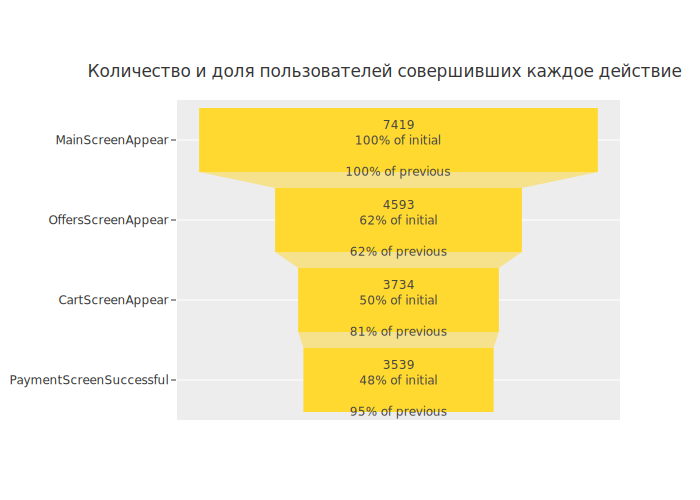

In [36]:
fig = go.Figure( go.Funnel(
        y=uniq_id_event[:4].index,
        x=uniq_id_event['id'], 
    textposition = 'inside', 
    textinfo = "value+percent previous+percent initial",
    marker = {"color": 'rgb(255,217,47)'}))
    
fig.update_layout(title={'text': "Количество и доля пользователей совершивших каждое действие", 'xanchor': 'center', 'y':0.87,
        'x':0.55})
fig.layout.template = 'ggplot2'
fig.show("svg")


Таким образом отчетливо видно: 
* Начальной точкой будет являться - Посещение главное экрана(**MainScreenAppear**), в котором присутствует 7419 уникальных пользователей, доля которых изначально 100%. 
* Второй этап - Появление экрана с предложениями(**OffersScreenAppear**) встречается 4593 раз и доля от предыдущего, первого этапа составляет 62%.
* Третий этап - Переход в корзину(**CartScreenAppear**) встречается 3734 раз и доля от предыдущего, второго этапа составляет 81%.
* Четвертый этап - Экран с успешной оплатой(**PaymentScreenSuccessful**) встречается 3539 раз и доля от прудыдущего , третьего этапа составояет 95%. 

### 4.5 На каком шаге теряете больше всего пользователей?

Познакомившись с воронкой событий отчетливо видны потери на каждом шаге. Таким образом основная часть отсекается после посещения главного меню 38%, не увидев экрана с предложениями. Еще 19 % по сравнению с предыдущим этапом отсекается так и не увидев корзину. И 5% от тех кто добавил в корзину в итоге не оплачивают, либо испытвают трудности с оплатой. 

### 4.6 Какая доля пользователей доходит от первого события до оплаты?

От первого этапа до момента успешной оплаты доходят 48% пользователей. 

## Этап 5. Изучение результатов эксперимента

### 5.1 Сколько пользователей в каждой экспериментальной группе?

Посмотрим сколько пользователей в каждой из экспериментальных групп:

In [37]:
exp_nun = filt_logs_exp.groupby('exp_id')['id'].nunique().to_frame()
exp_nun

,id
exp_id,
246,2484
247,2513
248,2537


В каждой группе примерно равное количество уникальных пользователей. 

### 5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Вспомним какие критерии необходимо соблюсти для успешного A/A теста:
* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Сделаем сегрегацию по группам экспреримента и посмотрим сколько уникальных пользователей совершили каждое из событий помимо знакомства с руководством(Tutorial):

Для группы 246:

In [38]:
uniq_id_event_246 = filt_logs_exp.query('exp_id == 246').groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
uniq_id_event_246['percent'] = uniq_id_event_246['id']/ uniq_id_event_246['id'][0] * 100
uniq_id_event_246[:4]

,id,percent
event,,
MainScreenAppear,2450,100.00
OffersScreenAppear,1542,62.94
CartScreenAppear,1266,51.67
PaymentScreenSuccessful,1200,48.98


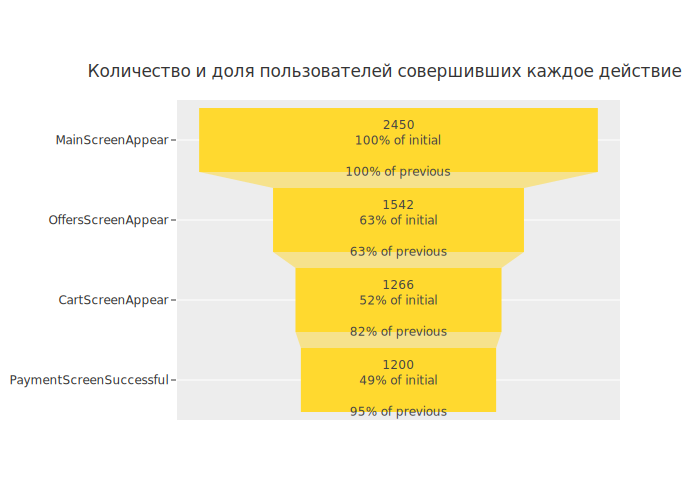

In [39]:
fig = go.Figure( go.Funnel(
        y=uniq_id_event_246[:4].index,
        x=uniq_id_event_246['id'], 
    textposition = 'inside', 
    textinfo = "value+percent previous+percent initial",
    marker = {"color": 'rgb(255,217,47)'}))
    
fig.update_layout(title={'text': "Количество и доля пользователей совершивших каждое действие", 'xanchor': 'center', 'y':0.87,
        'x':0.55})
fig.layout.template = 'ggplot2'
fig.show("svg")

Для группы 247:

In [40]:
uniq_id_event_247 = filt_logs_exp.query('exp_id == 247').groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
uniq_id_event_247['percent'] = uniq_id_event_247['id']/ uniq_id_event_247['id'][0] * 100
uniq_id_event_247[:4]

,id,percent
event,,
MainScreenAppear,2476,100.00
OffersScreenAppear,1520,61.39
CartScreenAppear,1238,50.00
PaymentScreenSuccessful,1158,46.77


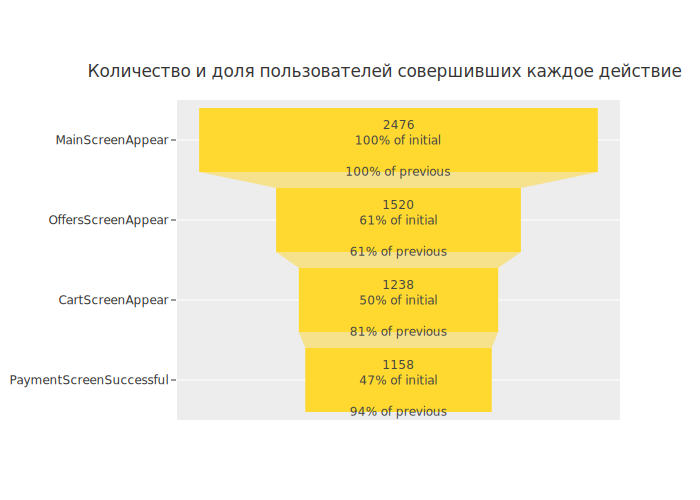

In [41]:
fig = go.Figure( go.Funnel(
        y=uniq_id_event_247[:4].index,
        x=uniq_id_event_247['id'], 
    textposition = 'inside', 
    textinfo = "value+percent previous+percent initial",
    marker = {"color": 'rgb(255,217,47)'}))
    
fig.update_layout(title={'text': "Количество и доля пользователей совершивших каждое действие", 'xanchor': 'center', 'y':0.87,
        'x':0.55})
fig.layout.template = 'ggplot2'
fig.show("svg")

Для группы 248:

In [42]:
uniq_id_event_248 = filt_logs_exp.query('exp_id == 248').groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
uniq_id_event_248['percent'] = uniq_id_event_248['id']/ uniq_id_event_248['id'][0] * 100
uniq_id_event_248[:4]

,id,percent
event,,
MainScreenAppear,2493,100.00
OffersScreenAppear,1531,61.41
CartScreenAppear,1230,49.34
PaymentScreenSuccessful,1181,47.37


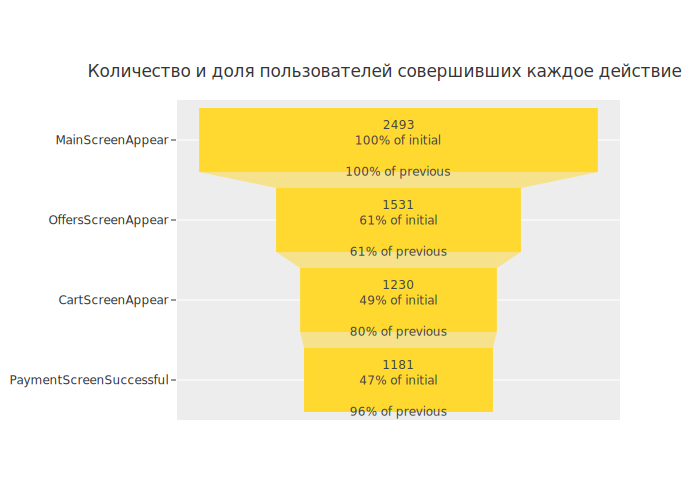

In [43]:
fig = go.Figure( go.Funnel(
        y=uniq_id_event_248[:4].index,
        x=uniq_id_event_248['id'], 
    textposition = 'inside', 
    textinfo = "value+percent previous+percent initial",
    marker = {"color": 'rgb(255,217,47)'}))
    
fig.update_layout(title={'text': "Количество и доля пользователей совершивших каждое действие", 'xanchor': 'center', 'y':0.87,
        'x':0.55})
fig.layout.template = 'ggplot2'
fig.show("svg")

Проверим разницу между группами:

In [44]:
(uniq_id_event_247.loc[:'PaymentScreenSuccessful','id'] / uniq_id_event_246.loc[:'PaymentScreenSuccessful','id'] * 100).to_frame()


,id
event,
MainScreenAppear,101.06
OffersScreenAppear,98.57
CartScreenAppear,97.79
PaymentScreenSuccessful,96.50


Критерии не идеальные, но приемлимые, особой разницы нет. Проверим нет ли пользователей, состоявших в обеих группах:

In [45]:
filt_logs_exp.groupby('id').agg({'exp_id':'nunique'}).reset_index().query('exp_id >=2')

,id,exp_id


Таких пользователей нет.

In [46]:
print('Количество пользователей, состоящие в обеих группах - {}'.format(filt_logs_exp.groupby('id').agg({'exp_id':'nunique'}).reset_index().query('exp_id >=2')['exp_id'].count()))

Количество пользователей, состоящие в обеих группах - 0


### 5.3 Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Посмотрим сколько уникальных пользователей совершили каждое событие в каждой из групп:

In [47]:
exp_ev_nun = filt_logs_exp.pivot_table(index = 'exp_id', columns ='event', values = 'id', aggfunc = 'nunique')
del exp_ev_nun['Tutorial']
exp_ev_nun

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
exp_id,,,,
246,1266,2450,1542,1200
247,1238,2476,1520,1158
248,1230,2493,1531,1181


Как можно заметить самое популярное событие это - переход на главный экран.

Объединим с количеством уникальных id для каждой из групп:

In [48]:
exp_ev_nun = pd.merge(exp_ev_nun, exp_nun, on = 'exp_id')
exp_ev_nun

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,id
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


Добавим строку с суммой групп 246 и 247 :

In [49]:
exp_ev_nun.loc['total(246+247)'] = (exp_ev_nun.eval(exp_ev_nun.loc[246] + exp_ev_nun.loc[247]))

Посмотрим на итоговую таблицу:

In [50]:
exp_ev_nun

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,id
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
total(246+247),2504,4926,3062,2358,4997


Для начала создадим функцию для Z-теста:

In [51]:
def z_test(exp1, exp2, event, alpha): 
    p1_ev = exp_ev_nun.loc[exp1, event]
    p2_ev = exp_ev_nun.loc[exp2, event] 
    p1_us = exp_ev_nun.loc[exp1, 'id'] 
    p2_us = exp_ev_nun.loc[exp2, 'id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Нулевой гипотезой будет являться то, что между группами нет статистически значимой разницы, в то время как альтернативная будет выражать то, что разница статистическая присуствует. Уровень alpha зададим как 5%. Проверим гипотезы:

In [52]:
for event in exp_ev_nun:
    if event != 'id':
        z_test(246, 247, event, 0.05)
        print()

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу



Таким образм нулевую гипотезу не отвергаем ни по одному из событий. A/A тест проведен корреектно.

### 5.4 Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Теперь проведем A/B тест и включим объединение контрольных групп(246 и 247) к экппериментальной(248) группе. Нулевой гипотезой будет являться то, что между группами нет статистически значимой разницы, в то время как альтернативная будет выражать то, что разница статистическая присутствует. Уровень alpha зададим как 5%. Проверим гипотезы для **246 и 248 группами**:

In [53]:
for event in exp_ev_nun:
    if event != 'id':
        z_test(246, 248, event, 0.05)
        print()

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу



Нулевую гипотезу не отвергаем ни по одному из событий между **группами 246 и 248**.

Проверим гипотезы для **247 и 248 группами:**

In [54]:
for event in exp_ev_nun:
    if event != 'id':
        z_test(247, 248, event, 0.05)
        print()

Проверка для  247 и 248, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу



Нулевую гипотезу не отвергаем ни по одному из событий между **группами 247 и 248.**

Проверим гипотезы для **контрольных групп(246 и 247) к экппериментальной(248) группе:**

In [55]:
for event in exp_ev_nun:
    if event != 'id':
        z_test('total(246+247)', 248, event, 0.05)
        print()

Проверка для  total(246+247) и 248, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для  total(246+247) и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  total(246+247) и 248, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для  total(246+247) и 248, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу



Нулевую гипотезу не отвергаем ни по одному из событий между событями для **контрольных групп(246 и 247) к экппериментальной(248) группе.**

### 5.5 Выводы

Мы провели множественный тест,4 A/A теста и 12 A/B тестов, брали несколько выборок из одного и того же набора данных. Особенность его заключается в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. В связи с этим мы должны скорректировать наши конечные p_value для сравнения их значений с alpha, но в этом нет необходимости, т.к. ни по одному из проведенных сравнений не обнаружилось статистически значимых различий.

**Решение**: Нет нужды продолжать тест, эксперимент с внедрением нового шрифта эффекта не дал ни в положительную, ни в отрицательную сторону.

## Этап 6. Общий вывод

Перед нами стояла задача разобраться как ведут себя пользователи мобильного приложения, который продает продукты питания и является стартапом. В нашем распоряжении был датасет с данными о действиях пользователей за 2 недели.

В процессе предобратки убедились, что в датасете нет отсутсвующих значений, помимо этого были изменены названия столбцов для удобства в работе, добавлены два столбца с датой и временем и отдельно с датой, также были удалены дубликаты из имеющихся данных.

Следующим этапом являлось - изучение и проверки данных, в ходе которых было выявлено:
* В логе содержатся 243713 событий
* В логе содержатся данные 7551 пользователей
* В среднем на пользователя приходится 32 события
* Данные предоставлены с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 число
* Полные данные имеются с 2019-08-01, за одну неделю
* Отбросив старые данные потеряли 2826 событий, в процентном соотношении 1.16%
* Отбросив старые данные потеряли данные 17 пользователей, в процентном соотношении 0.23%
* Для 246 группы имеется 2484 уникальных пользователя, для 247 группы - 2513 пользователя, для 248 группы - 2537 пользователя
* Для 246 группы имеется 79302 события, для 247 группы - 77022 события, для 248 группы - 84563 события.

После была изучена воронка событий и здесь было выявлено следующее:
* Имеются 5 групп событий:
1. MainScreenAppear - Переход на главный экран, встречается 117328 раз
2. OffersScreenAppear - Появление экрана с предложениями, встречается 46333 раз
3. CartScreenAppear - Переход на экран с корзиной, встречается 42393 раз
4. PaymentScreenSuccessful - Экран с успешной оплатой, встречается 33918 раз
5. Tutorial - Руководство, встречается 1005 раз
* Для данных событий была составлена воронка событий, которая показала:
1. Начальной точкой будет являться - Посещение главное экрана(**MainScreenAppear**), в котором присутствует 7419 уникальных пользователей, доля которых изначально 100%. 
2. Второй этап - Появление экрана с предложениями(**OffersScreenAppear**) встречается 4593 раз и доля от предыдущего, первого этапа составляет 62%.
3. Третий этап - Переход в корзину(**CartScreenAppear**) встречается 3734 раз и доля от предыдущего, второго этапа составляет 81%.
4. Четвертый этап - Экран с успешной оплатой(**PaymentScreenSuccessful**) встречается 3539 раз и доля от прудыдущего , третьего этапа составояет 95%. 
* Основная доля пользователей терятся после перехода на главное меню.
* От первого этапа до момента успешной оплаты доходят 48% пользователей.

Последним шагом было изучение экпериментов, в ходе которого мы выявили:
* В каждой группе примерно равное количество уникальных пользователей.
* Нет статистически значимых различий при A/A теста, нулевая гипотеза не отвергнута.
* Самое популярное действие - переход на главный экран
* Нулевую гипотезу не отвергаем ни по одному из событий между группами 246 и 248.
* Нулевую гипотезу не отвергаем ни по одному из событий между группами 247 и 248.
* Нулевую гипотезу не отвергаем ни по одному из событий между событями для контрольных групп(246 и 247) к экппериментальной(248) группе.

Решение: Нет нужды продолжать тест, эксперимент с внедрением нового шрифта эффекта не дал ни в положительную, ни в отрицательную сторону.

*Примечание: Требуются более качественные данные, так как имелись дубликаты и полные данные предлагались лишь за неделю.*